In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from wordcloud import WordCloud

In [2]:
def load_data(filename,cols):
    dataset = pd.read_csv(filename,usecols=cols,encoding="latin1")
    dataset = dataset[cols]
    return dataset

In [3]:
cols = ["id","keyword","location","text","target"]
filename = "twitter_disaster.csv"
dataset = load_data(filename,cols)

In [4]:
dataset.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


We can straight away see that the dataset consists of multiple nan values in keywords and location columns.

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


location has a lot of nan values

In [6]:
dataset.apply(lambda x: sum(x.isnull()))

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

Replacing the null values to perform further analysis

In [7]:
dataset.keyword.fillna('no_keyword', inplace = True)
dataset.location.fillna('no_location', inplace = True)
dataset.apply(lambda x: sum(x.isnull()))

id          0
keyword     0
location    0
text        0
target      0
dtype: int64

In [8]:
dataset.apply(lambda x: len(x.unique()))

id          7613
keyword      222
location    3342
text        7503
target         2
dtype: int64

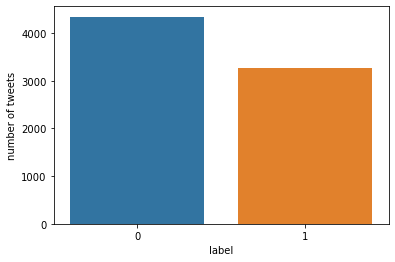

In [9]:
target_count = dataset['target'].value_counts()
sns.barplot(x = target_count.index, y = target_count);
plt.xlabel('label');
plt.ylabel('number of tweets');

Here we can see that the imbalance between the two classes is not significant

## Location Analysis

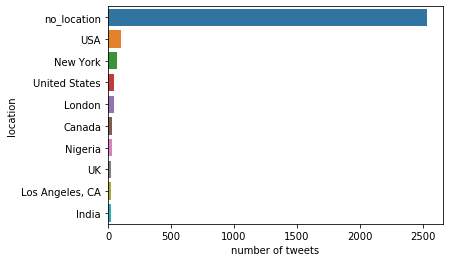

In [10]:
top_10_location = dataset.groupby(['location']).count().text.sort_values(ascending = False)[:10]
sns.barplot(x = top_10_location, y = top_10_location.index);
plt.xlabel('number of tweets');

The list of location includes strings like 'earth' or 'Everywhere'. It's because this field is not auto generated and hence cannot be used in the model

In [11]:
dataset.drop('location',axis=1,inplace=True)

## Keyword Analysis

In [12]:
dataset.groupby(['keyword']).count().text.sort_values(ascending = False)

keyword
no_keyword               61
fatalities               45
deluge                   42
armageddon               42
body%20bags              41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: text, Length: 222, dtype: int64

We can see that majority of tweets do not have a keywod

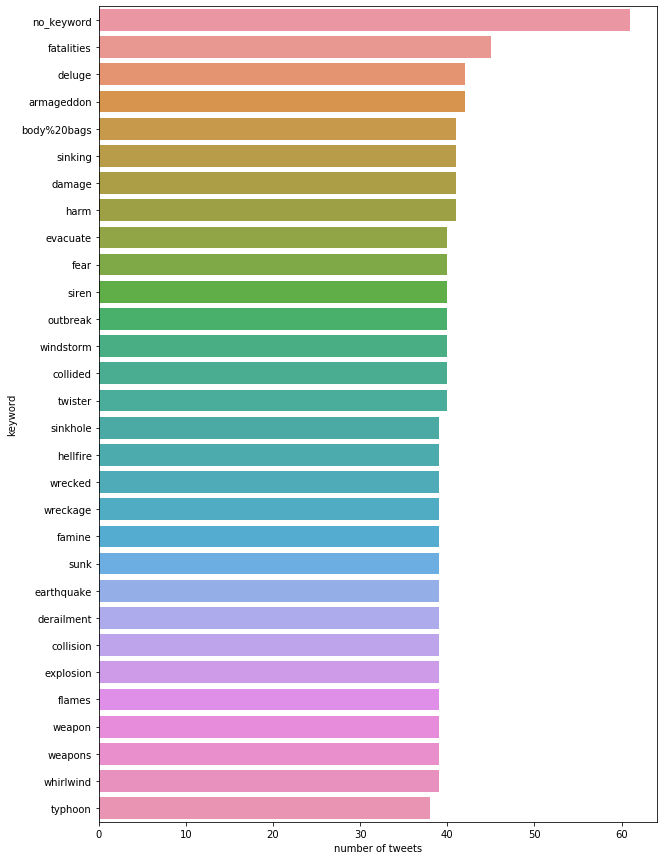

In [13]:
top_30_keyword = dataset.groupby(['keyword']).count().text.sort_values(ascending = False)[:30]
plt.figure(figsize = (10,15))
sns.barplot(x = top_30_keyword, y = top_30_keyword.index);
plt.xlabel('number of tweets');

[Text(0, 0.5, 'keywords'),
 Text(0.5, 0, 'number of tweets'),
 Text(0.5, 1.0, 'Non Disaster Tweets')]

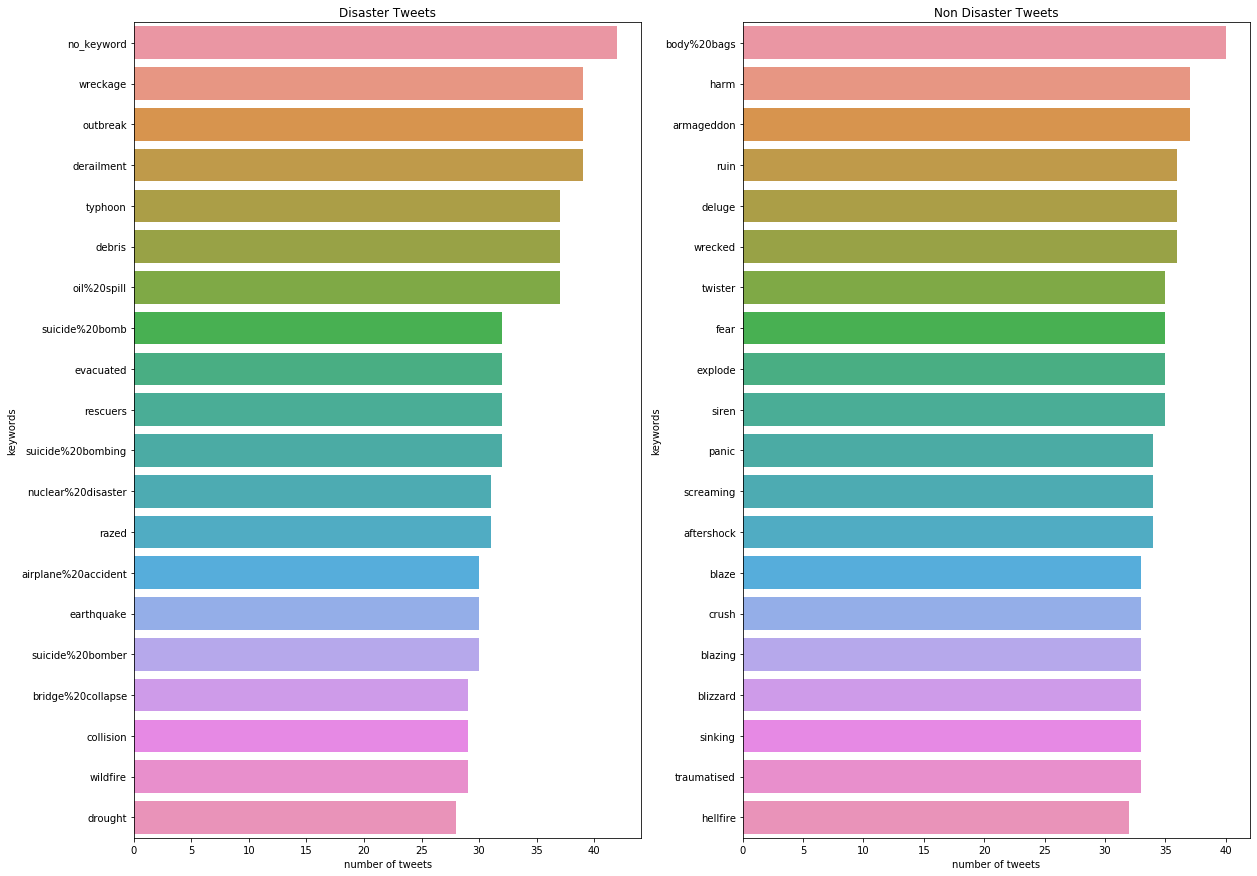

In [14]:
fig,axes=plt.subplots(1,2,figsize=(20,15))
top_20_disaster_keywords = dataset[dataset.target == 1].groupby(['keyword']).count().text.sort_values(ascending = False)[:20]
sns.barplot(x = top_20_disaster_keywords, y = top_20_disaster_keywords.index,ax=axes[0]);
top_20_non_disaster_keywords = dataset[dataset.target == 0].groupby(['keyword']).count().text.sort_values(ascending = False)[:20]
sns.barplot(x = top_20_non_disaster_keywords, y = top_20_non_disaster_keywords.index,ax=axes[1]);
axes[0].set(ylabel="keywords", xlabel="number of tweets", title="Disaster Tweets")
axes[1].set(ylabel="keywords", xlabel="number of tweets", title="Non Disaster Tweets")

In [15]:
common_keywords = np.intersect1d(top_20_disaster_keywords.index, top_20_non_disaster_keywords.index)
print(common_keywords)

[]


We can see that there are no common keywords between the top twenty disaster and non disaster tweets.<br>
Hence keywords can prove to be an important feature, but we have to clean them before using it in our model.<br>
Also we can see that a lot of Disaster tweets have no keyword.

In [18]:
dataset['keyword'] = dataset.keyword.apply(lambda x:  re.sub('%20','_', x))

## Meta Features

Generating and analyzing meta features

In [19]:
stop_words = stopwords.words('english')
stop_words.remove('not')
# word_count
dataset['word_count'] = dataset['text'].apply(lambda x: len(str(x).split()))
# unique_word_count
dataset['unique_word_count'] = dataset['text'].apply(lambda x: len(set(str(x).split())))
# stop_word_count
dataset['stop_word_count'] = dataset['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in stop_words]))
# url_count
dataset['url_count'] = dataset['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
# mean_word_length
dataset['mean_word_length'] = dataset['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
# char_count
dataset['char_count'] = dataset['text'].apply(lambda x: len(str(x)))
# punctuation_count
dataset['punctuation_count'] = dataset['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
# hashtag_count
dataset['hashtag_count'] = dataset['text'].apply(lambda x: len([c for c in str(x) if c == '#']))
# mention_count
dataset['mention_count'] = dataset['text'].apply(lambda x: len([c for c in str(x) if c == '@']))

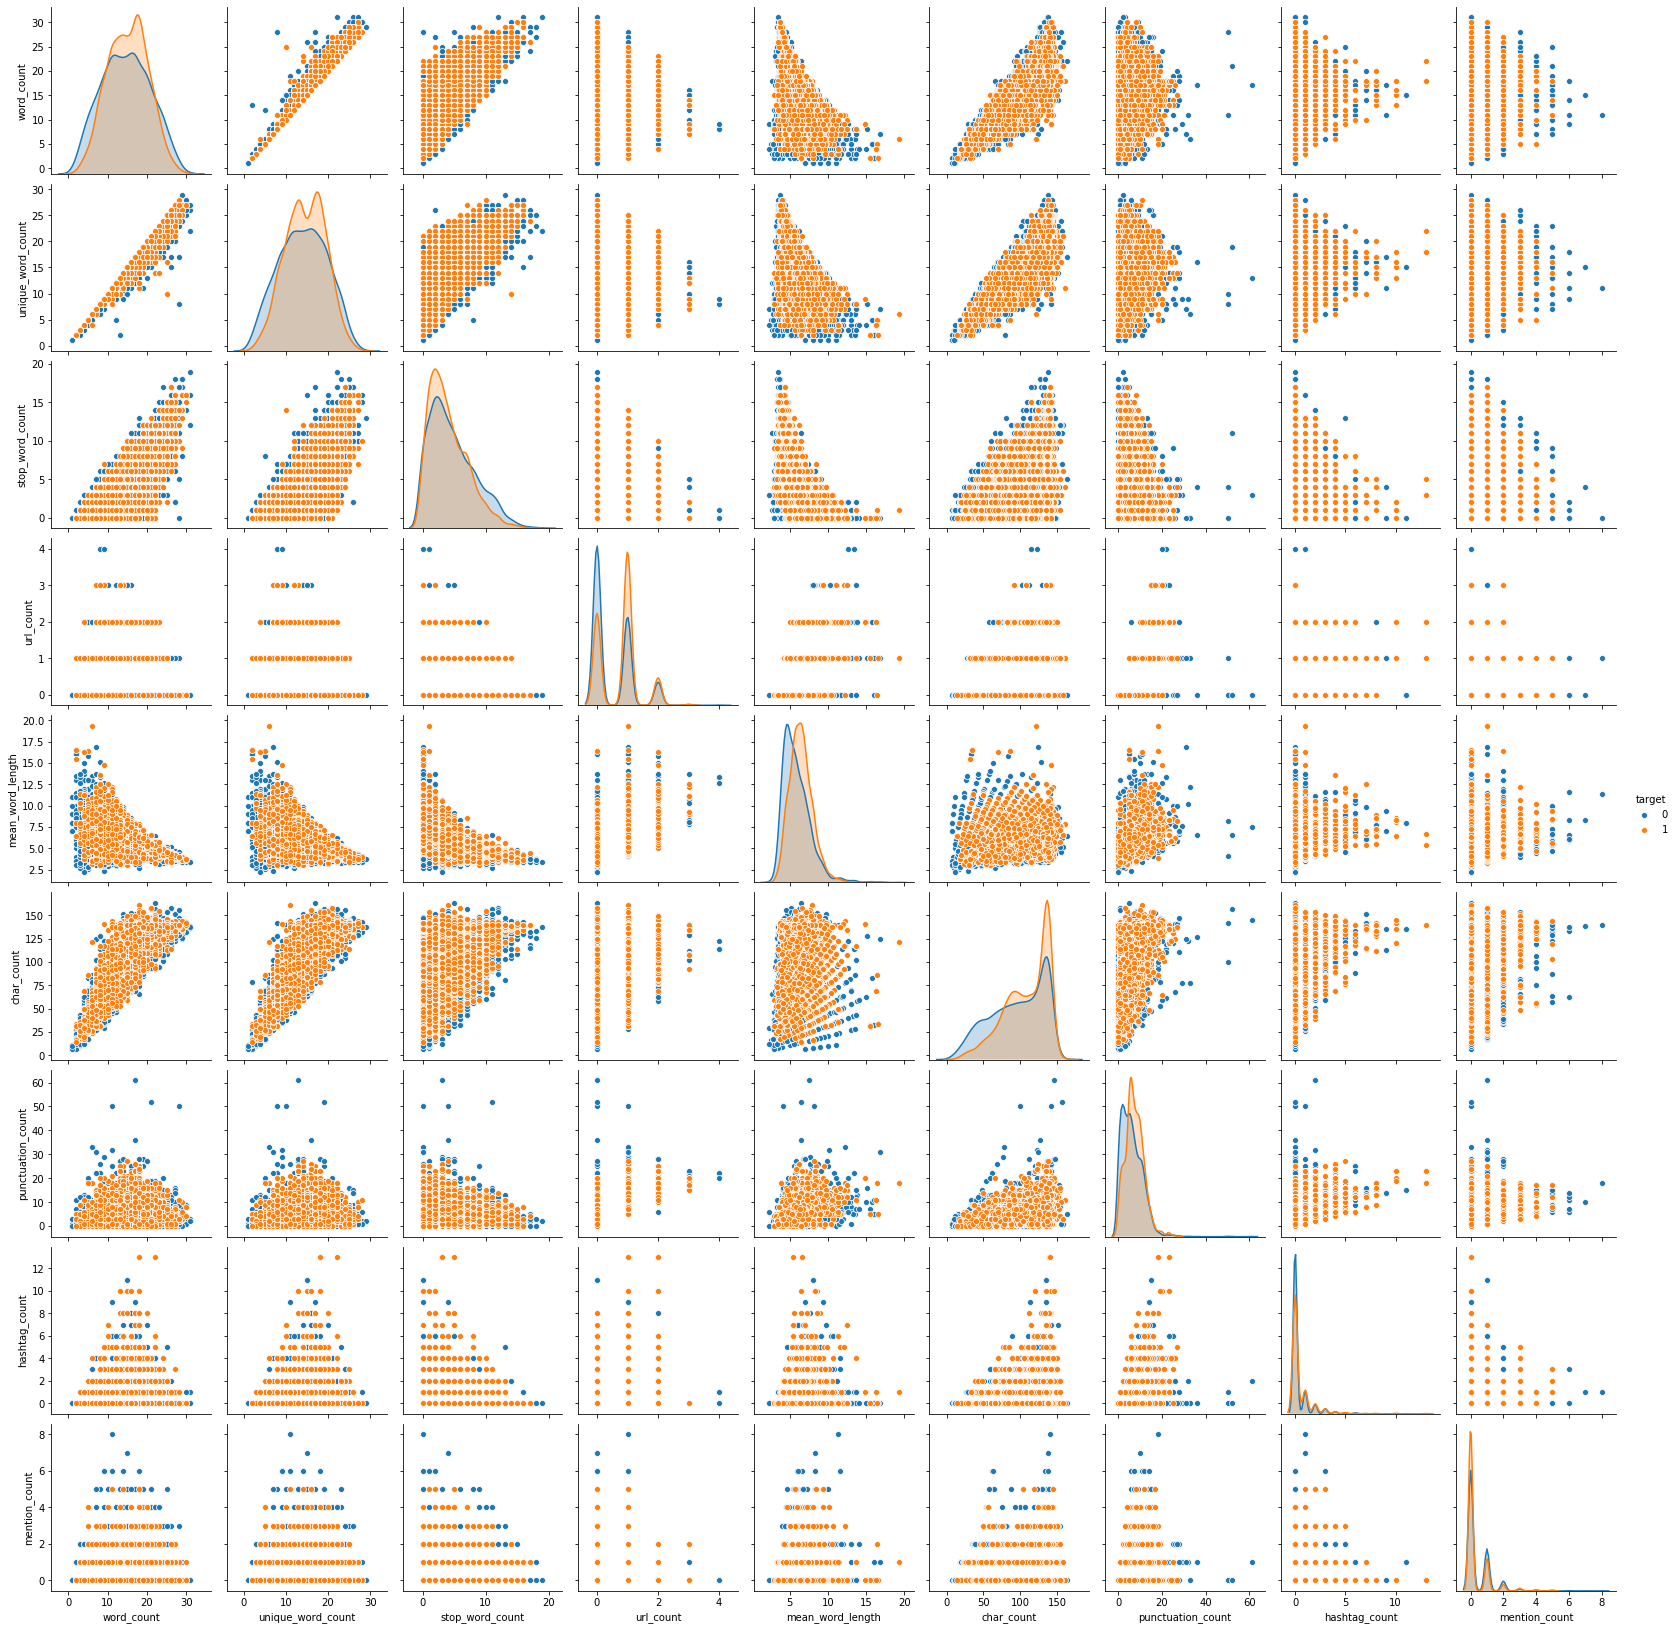

In [20]:
features = ['word_count', 'unique_word_count', 'stop_word_count', 'url_count', 'mean_word_length','char_count', 'punctuation_count', 'hashtag_count', 'mention_count','target']
sns.pairplot(dataset[features], hue='target')

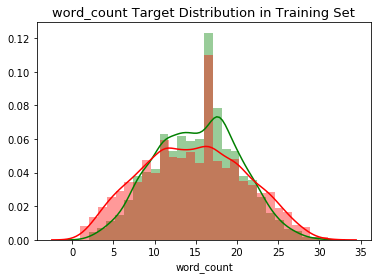

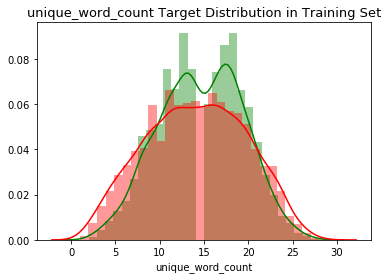

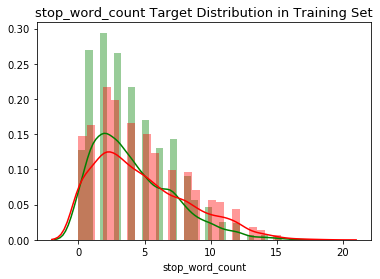

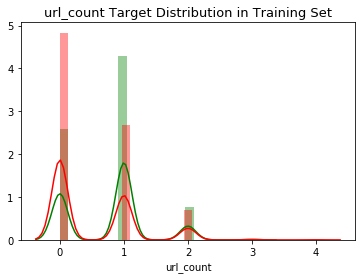

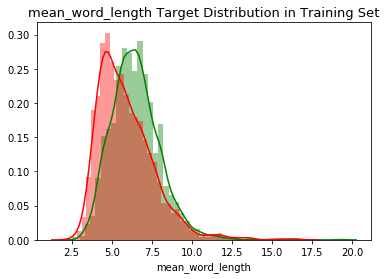

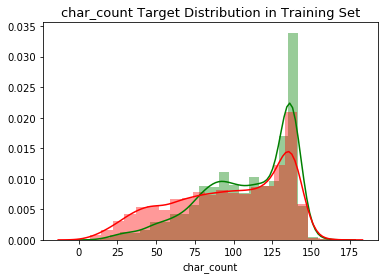

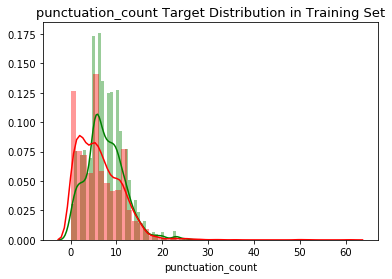

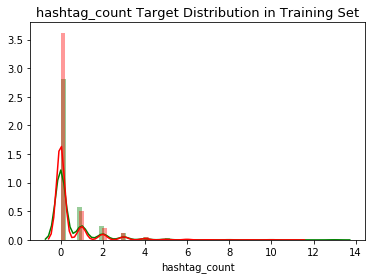

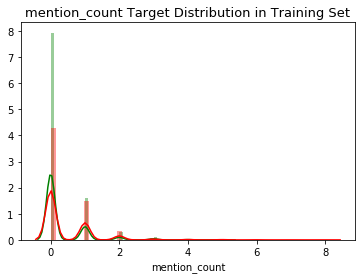

In [21]:
features = ['word_count', 'unique_word_count', 'stop_word_count', 'url_count', 'mean_word_length','char_count', 'punctuation_count', 'hashtag_count', 'mention_count']
for i, feature in enumerate(features):
    ax=sns.distplot(dataset.loc[dataset['target'] == 1][feature], label = 1, color = 'green')
    sns.distplot(dataset.loc[dataset['target'] == 0][feature], label = 0, color = 'red', ax=ax)
    ax.set_title(f'{feature} Target Distribution in Training Set', fontsize = 13)
    plt.show()

All of the meta features have information about target as well, but some of them are not good enough such as url_count, hashtag_count and mention_count.

On the other hand, word_count, unique_word_count, stop_word_count, mean_word_length, char_count, punctuation_count have slightly different distributions for disaster and non-disaster tweets. Those features might be useful in models.

In [22]:
dataset.drop(['url_count','hashtag_count','mention_count'],axis=1,inplace=True)

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
features = {
"f1":u"word_count",
"f2":u"unique_word_count",
"f3":u"stop_word_count",
"f4":u"mean_word_length",
"f5":u"char_count",
"f6":u"punctuation_count",
}

Feature ranking:
1. mean_word_length 0.303733 
2. char_count 0.233516 
3. punctuation_count 0.171169 
4. stop_word_count 0.155873 
5. unique_word_count 0.088686 
6. word_count 0.047024 


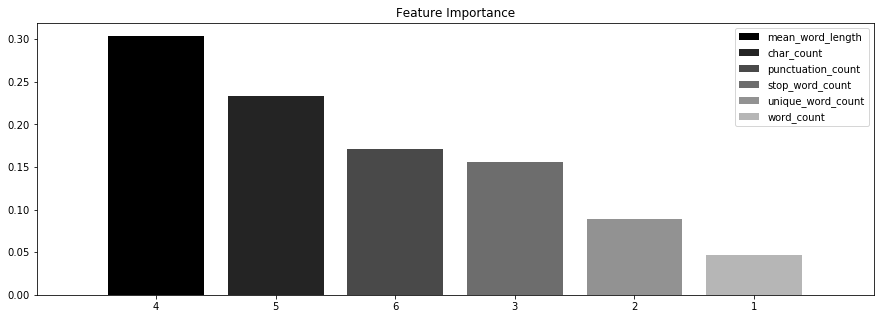

In [24]:
forest = RandomForestClassifier(n_estimators=600, max_features=6,random_state=0)
forest.fit(dataset.drop(['id','keyword','text','target'], axis=1), dataset['target'])
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]
# Plot the feature importancies of the forest
num_to_plot = 6
feature_indices = [ind+1 for ind in indices[:num_to_plot]]

# Print the feature ranking
print("Feature ranking:")
  
for f in range(num_to_plot):
    print("%d. %s %f " % (f + 1, 
            features["f"+str(feature_indices[f])], 
            importances[indices[f]]))
plt.figure(figsize=(15,5))
plt.title(u"Feature Importance")
bars = plt.bar(range(num_to_plot), importances[indices[:num_to_plot]], color=([str(i/float(num_to_plot+1)) for i in range(num_to_plot)]),align="center")
ticks = plt.xticks(range(num_to_plot), feature_indices)
plt.xlim([-1, num_to_plot])
plt.legend(bars, [u''.join(features["f"+str(i)]) for i in feature_indices]);

Feature ranking:
1. mean_word_length 0.301272 
2. char_count 0.229654 
3. stop_word_count 0.166754 
4. punctuation_count 0.152013 
5. unique_word_count 0.102490 
6. word_count 0.047817 


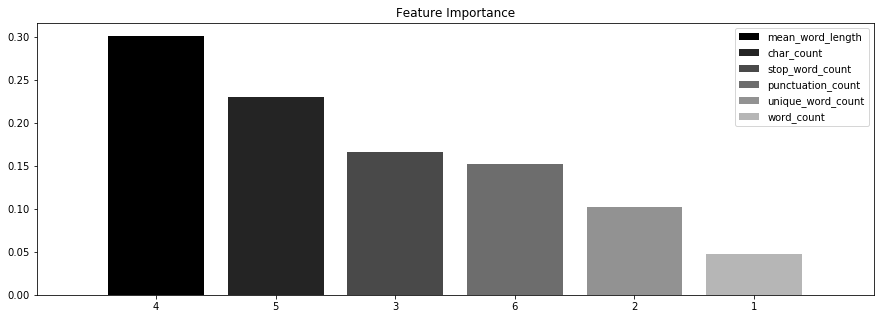

In [25]:
tree = DecisionTreeClassifier(max_features=6,random_state=0)
tree.fit(dataset.drop(['id','keyword','text','target'], axis=1), dataset['target'])
importances = tree.feature_importances_

indices = np.argsort(importances)[::-1]
# Plot the feature importancies of the forest
num_to_plot = 6
feature_indices = [ind+1 for ind in indices[:num_to_plot]]

# Print the feature ranking
print("Feature ranking:")
  
for f in range(num_to_plot):
    print("%d. %s %f " % (f + 1, 
            features["f"+str(feature_indices[f])], 
            importances[indices[f]]))
plt.figure(figsize=(15,5))
plt.title(u"Feature Importance")
bars = plt.bar(range(num_to_plot), importances[indices[:num_to_plot]], color=([str(i/float(num_to_plot+1)) for i in range(num_to_plot)]),align="center")
ticks = plt.xticks(range(num_to_plot), feature_indices)
plt.xlim([-1, num_to_plot])
plt.legend(bars, [u''.join(features["f"+str(i)]) for i in feature_indices]);

By analyzing the feature importance graphs obtained from Random Forest and Decision Tree Classifiers we can see that mean_word_length and char_count prove to be two important features and we can further se them in our analysis

In [26]:
dataset.drop(columns = ['unique_word_count', 'stop_word_count','punctuation_count','word_count','id'], inplace = True)

## Text Preprocessing

In [27]:
dataset.loc[dataset['text'] == 'like for the music video I want some real action shit like burning buildings and police chases not some weak ben winston shit', 'target_relabeled'] = 0
dataset.loc[dataset['text'] == 'Hellfire is surrounded by desires so be careful and donÛªt let your desires control you! #Afterlife', 'target_relabeled'] = 0
dataset.loc[dataset['text'] == 'To fight bioterrorism sir.', 'target_relabeled'] = 0
dataset.loc[dataset['text'] == '.POTUS #StrategicPatience is a strategy for #Genocide; refugees; IDP Internally displaced people; horror; etc. https://t.co/rqWuoy1fm4', 'target_relabeled'] = 1
dataset.loc[dataset['text'] == 'CLEARED:incident with injury:I-495  inner loop Exit 31 - MD 97/Georgia Ave Silver Spring', 'target_relabeled'] = 1
dataset.loc[dataset['text'] == '#foodscare #offers2go #NestleIndia slips into loss after #Magginoodle #ban unsafe and hazardous for #humanconsumption', 'target_relabeled'] = 0
dataset.loc[dataset['text'] == 'In #islam saving a person is equal in reward to saving all humans! Islam is the opposite of terrorism!', 'target_relabeled'] = 0
dataset.loc[dataset['text'] == 'Who is bringing the tornadoes and floods. Who is bringing the climate change. God is after America He is plaguing her\n \n#FARRAKHAN #QUOTE', 'target_relabeled'] = 1
dataset.loc[dataset['text'] == 'RT NotExplained: The only known image of infamous hijacker D.B. Cooper. http://t.co/JlzK2HdeTG', 'target_relabeled'] = 1
dataset.loc[dataset['text'] == "Mmmmmm I'm burning.... I'm burning buildings I'm building.... Oooooohhhh oooh ooh...", 'target_relabeled'] = 0
dataset.loc[dataset['text'] == "wowo--=== 12000 Nigerian refugees repatriated from Cameroon", 'target_relabeled'] = 0
dataset.loc[dataset['text'] == "He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam", 'target_relabeled'] = 0
dataset.loc[dataset['text'] == "Hellfire! We donÛªt even want to think about it or mention it so letÛªs not do anything that leads to it #islam!", 'target_relabeled'] = 0
dataset.loc[dataset['text'] == "The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.'", 'target_relabeled'] = 0
dataset.loc[dataset['text'] == "Caution: breathing may be hazardous to your health.", 'target_relabeled'] = 1
dataset.loc[dataset['text'] == "I Pledge Allegiance To The P.O.P.E. And The Burning Buildings of Epic City. ??????", 'target_relabeled'] = 0
dataset.loc[dataset['text'] == "#Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect", 'target_relabeled'] = 0
dataset.loc[dataset['text'] == "that horrible sinking feeling when youÛªve been at home on your phone for a while and you realise its been on 3G this whole time", 'target_relabeled'] = 0

In [33]:
def preprocess_data(tweet):
    # Remove urls
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)
    # Remove html tags
    tweet = re.sub(r'<.*?>','', tweet, flags=re.MULTILINE)
    # Remove user @ references and '#' from tweet
    tweet = re.sub(r'\@\w+|\#','', tweet)
    #Converting tweet to lowercase
    tweet = tweet.lower()
    # Remove punctuations
    tweet = re.sub('[^a-z]', ' ',tweet)
    # Tokenize
    tweet = tweet.split()
    # Filtering out stopwords and applying stemming
    lemmatizer = WordNetLemmatizer() 
    stop_words = stopwords.words('english')
    tweet = [lemmatizer.lemmatize(word) for word in tweet if not word in set(stop_words)]
    # Joining all the tokens together
    tweet = ' '.join(tweet)
    return tweet

In [34]:
dataset['text'] = dataset.text.apply(lambda x: preprocess_data(x))

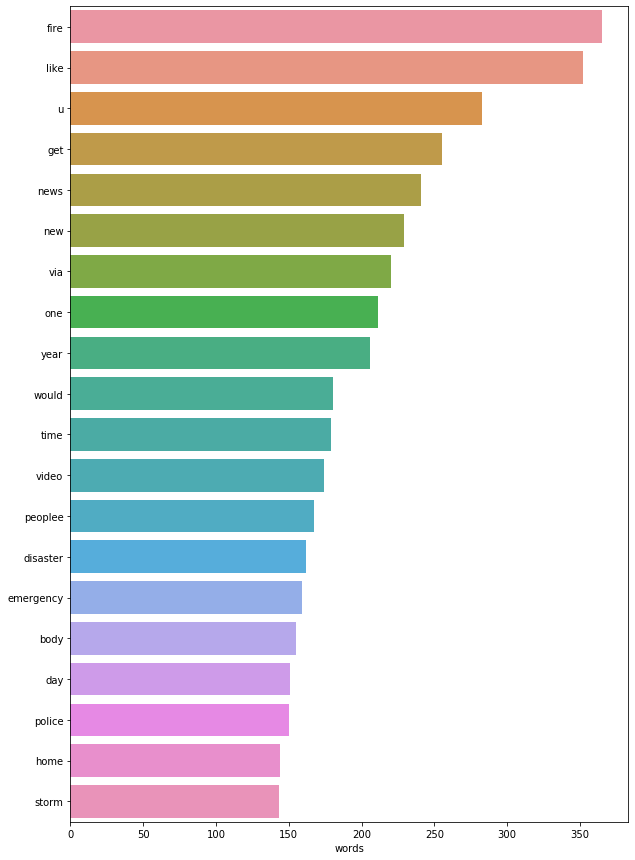

In [35]:
from nltk import FreqDist, word_tokenize
word_freq = FreqDist(word for word in word_tokenize(' '.join(dataset['text']).lower()))
df_word_freq = pd.DataFrame.from_dict(word_freq, orient='index', columns=['count'])
top_20_words = df_word_freq.sort_values('count',ascending=False).head(20)
plt.figure(figsize = (10,15))
sns.barplot(x = top_20_words['count'], y = top_20_words.index);
plt.xlabel('word count');
plt.xlabel('words');

[Text(0, 0.5, 'words'),
 Text(0.5, 0, 'word count'),
 Text(0.5, 1.0, 'Non Disaster Tweets')]

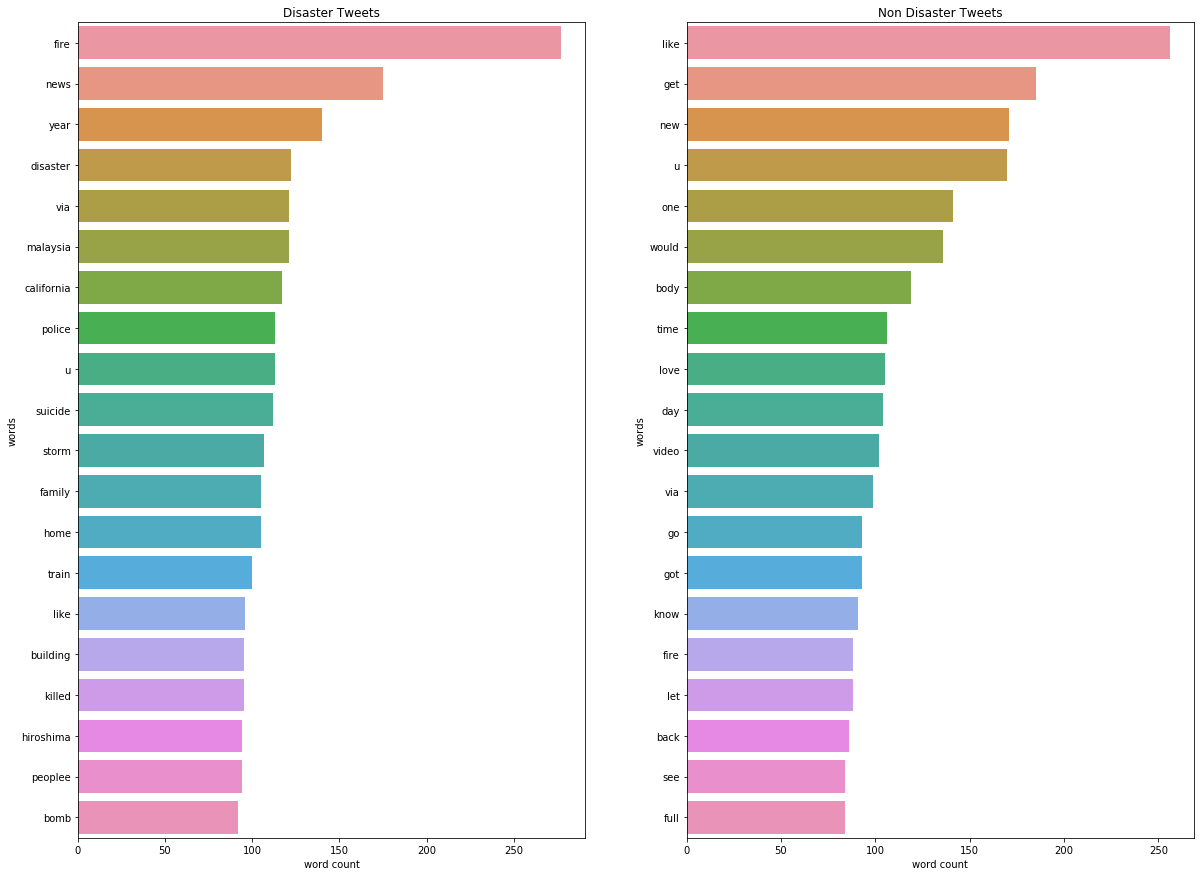

In [36]:
dis_word_freq = FreqDist(word for word in word_tokenize(' '.join(dataset[dataset.target == 1]['text'].values).lower()))
df_dis_word_freq = pd.DataFrame.from_dict(dis_word_freq, orient='index', columns=['count'])
top_20_dis_words = df_dis_word_freq.sort_values('count',ascending=False).head(20)

non_dis_word_freq = FreqDist(word for word in word_tokenize(' '.join(dataset[dataset.target == 0]['text'].values).lower()))
df_non_dis_word_freq = pd.DataFrame.from_dict(non_dis_word_freq, orient='index', columns=['count'])
top_20_non_dis_words = df_non_dis_word_freq.sort_values('count',ascending=False).head(20)

fig,axes=plt.subplots(1,2,figsize=(20,15))
sns.barplot(x = top_20_dis_words['count'], y = top_20_dis_words.index, ax=axes[0]);
sns.barplot(x = top_20_non_dis_words['count'], y = top_20_non_dis_words.index, ax=axes[1]);
axes[0].set(ylabel="words", xlabel="word count", title="Disaster Tweets")
axes[1].set(ylabel="words", xlabel="word count", title="Non Disaster Tweets")

Words like 'fire', 'like', 'u' and 'via' are commonly used in both disaster as well as non disaster tweets.

In [37]:
common_words = np.intersect1d(top_20_dis_words.index, top_20_non_dis_words.index)
print(common_words)

['fire' 'like' 'u' 'via']


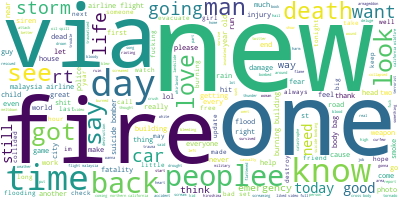

In [38]:
data = ','.join(dataset['text'].values).lower()
wc = WordCloud(background_color="white",
               max_words=5000, contour_width=3,
               contour_color='steelblue')
wc.generate(data)
wc.to_image()

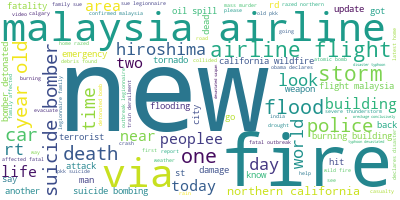

In [39]:
real_data = ','.join(dataset[dataset.target == 1]['text'].values).lower()
wc.generate(real_data)
wc.to_image()

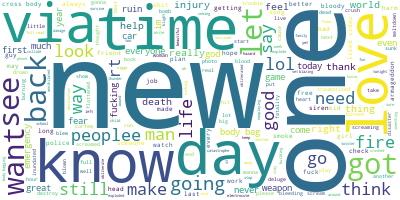

In [40]:
fake_data = ','.join(dataset[dataset.target == 0]['text'].values)
wc.generate(fake_data)
wc.to_image()

In [41]:
dataset.to_csv('cleaned_train.csv',index=False)